We want to estimate the effect of 401(k) eligibility on net financial assets using double machine learning as in [this paper](https://arxiv.org/abs/1608.00060) with data from [here](https://github.com/kquist/DoubleML-Python).

In [1]:
import pandas as pd
df = pd.read_stata('sipp1991.dta')

print(df.shape)

df.sample(10)

(9915, 14)


,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
5539,0.0,-315.0,3685.0,31,11364.0,4,12,0,1,0,0,0,0,0
5075,0.0,0.0,0.0,25,10200.0,1,9,0,0,0,0,0,0,0
5568,0.0,0.0,0.0,33,13380.0,1,12,0,0,0,0,0,0,0
1419,10300.0,10300.0,22300.0,40,16875.0,4,12,1,1,0,0,0,0,1
4816,12499.0,57499.0,83599.0,44,33774.0,3,14,0,1,0,0,0,1,1
7754,1999.0,23999.0,32999.0,40,87030.0,4,15,0,1,1,1,1,0,0
4976,610.0,-1190.0,4810.0,34,9792.0,2,12,0,0,0,0,0,0,1
9387,28500.0,53650.0,88775.0,43,64659.0,1,16,1,0,0,1,1,1,1
9249,1560.0,-4140.0,-3140.0,38,13668.0,3,13,0,0,0,1,1,0,0
6135,900.0,-2719.0,5581.0,27,25971.0,3,14,0,1,1,0,0,0,1


# Estimator

As in [this paper](https://arxiv.org/abs/1608.00060), the model is
$$Y = T\cdot\theta + m_Y(X) + R_Y,$$
$$T = m_T(X) + R_T.$$
with $E[R_Y|X, T] = 0$ and $E[R_T|X] = 0$. To estimate $\theta$,
1. Partition the data set into $I_1$ and $I_2$.
1. For $k=1,2$
    1. Fit $Y$ versus $X$ on $I_k$ to approximate $m_Y$. Compute the residual $R_Y$ on $I_k^C$.
    1. Fit $T$ versus $X$ on $I_k$ to approximate $m_T$. Compute the residual $R_T$ on $I_k^C$.
    1. Fit a linear model for $R_Y$ versus $R_T$, giving an estimate $\theta_{k}$ for $\theta$.
1. Average $\theta_1$ and $\theta_{2}$.

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression


    theta_1 = np.mean(np.dot(R_T,R_Y))/np.mean(np.dot(R_T,D[I_C]))


class DoubleML():
    
    def __init__(self, n_split=2, n_repeat=1):
        self.LinearModel = LinearRegression()
        self.n_split = n_split
        self.n_repeat = n_repeat
    
    def set_model(self, M):
        self.Model = M
        return self

    def set_df(self, df):
        self.df = df
        return self
    
    def split_df(self):
        
        # Split
        self.dfs = []
        indices = np.random.permutation(self.df.index)
        for i in np.array_split(indices, self.n_split):
            self.dfs.append(df.loc[i])

        # For two split...
        # self.df1 = df.sample(frac=0.5)
        # self.df2 = df.drop(self.df1.index)
        
        return self

    def set_outcomes(self, o):
        self.outcomes = o
        return self

    def set_treatments(self, t):
        self.treatments = t
        return self

    def set_controls(self, c=None):
        
        # Assign remaining columns if controls not set
        if c is None:
            c = [
                col for col in self.df.columns
                if col not in self.outcomes
                and col not in self.treatments
            ]
        
        self.controls = c
        return self

    def get_residual(self, df1, x, y, model):
        
        X1 = df1[x]
        Y1 = df1[y]
        
        # Define complement
        df2 = self.df.drop(df1.index)

        X2 = df2[x]
        Y2 = df2[y]
        
        Y2_pred = pd.DataFrame(columns=y, index=df2.index)
        
        # FIXME need to reshape before/after sklearn 
        Y2_pred.loc[:,y] = model.fit(X1, Y1.values.ravel()).predict(X2).reshape(-1, len(y))
        residual = Y2 - Y2_pred
        
        return residual
        
    def crossfit(self, df1):
        
        # Treatments vs Controls
        residual_tc = self.get_residual(
            df1, self.controls, self.treatments, self.Model
        )
        
        # Outcomes vs Controls
        residual_oc = self.get_residual(
            df1, self.controls, self.outcomes, self.Model
        )
        
        # Second vs First Residuals
        coef = self.LinearModel\
            .fit(residual_tc, residual_oc)\
            .coef_
        
        return pd.DataFrame(coef, columns=treatments)
    
    def k_crossfit(self):
        
        coefs = []
        
        for df in self.dfs:
            coef = self.crossfit(df)
            coefs.append(coef)
        
        return pd.concat(coefs).reset_index(drop=True).mean().to_frame().transpose()
        
    def estimate(self):
        
        estimates = []
        for _ in range(self.n_repeat):
            estimate = self.split_df().k_crossfit()
            estimates.append(estimate)

        return pd.concat(estimates).reset_index(drop=True)

# Example

Let's apply this to the data set.

In [3]:
from sklearn.ensemble import RandomForestRegressor

outcomes = ["nifa"]
treatments = ["marr"]

model = RandomForestRegressor(max_depth=2)

estimates = DoubleML(n_split=2, n_repeat=100)\
.set_model(model)\
.set_df(df)\
.set_outcomes(outcomes)\
.set_treatments(treatments)\
.set_controls()\
.estimate()

              marr
count   100.000000
mean   4265.956859
std     367.678340
min    3295.722071
25%    4054.192725
50%    4242.470540
75%    4498.549122
max    5086.727205


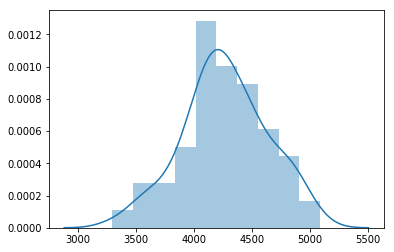

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# estimates.hist(bins=10)

import seaborn as sns
from scipy import stats

sns.distplot(estimates)
print(estimates.describe())

# Further Reading

For other examples, see [here](http://aeturrell.github.io/home/2018/02/10/econometrics-in-python-partI-ML/).